# Data Cleaning For Mapping

In [1]:
import pandas as pd
df = pd.read_csv('gene_labels.csv')

In [2]:
print(df)

     Metadata_Symbol  Metadata_NCBI_Gene_ID  Indeterminate  Negative  \
0                A2M                      2              2         1   
1            A3GALT2                 127550              3         0   
2             A4GALT                  53947              1         0   
3              A4GNT                  51146              4         0   
4               AACS                  65985              3         0   
...              ...                    ...            ...       ...   
7970         ZSCAN32                  54925              4         0   
7971          ZSCAN4                 201516              0         0   
7972         ZSCAN5A                  79149              0         0   
7973          ZSCAN9                   7746              0         0   
7974          ZSWIM2                 151112              1         0   

      Positive     gene_label  
0            2  Indeterminate  
1            2  Indeterminate  
2            4       Positive  
3      

In [3]:
# Extract the gene ID and the label from gene_labels.csv and create new dataframe with values
gene_id = df['Metadata_NCBI_Gene_ID']
label = df['gene_label']
new_df = pd.DataFrame({'GeneID (EntrezGene)': gene_id, 'Label': label})
print(new_df)
all_genes_df = new_df.to_excel('all_genes_ids.xlsx', index=False)

      GeneID (EntrezGene)          Label
0                       2  Indeterminate
1                  127550  Indeterminate
2                   53947       Positive
3                   51146  Indeterminate
4                   65985  Indeterminate
...                   ...            ...
7970                54925  Indeterminate
7971               201516       Positive
7972                79149       Positive
7973                 7746       Positive
7974               151112       Positive

[7975 rows x 2 columns]


In [4]:
# Read the Excel file into a DataFrame
uniprot_df = pd.read_excel("HUMAN_9606_idmapping.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207780 entries, 0 to 207779
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   UniProtKB-AC         207780 non-null  object 
 1   UniProtKB-ID         207780 non-null  object 
 2   GeneID (EntrezGene)  32751 non-null   object 
 3   Unnamed: 3           34412 non-null   object 
 4   Unnamed: 4           126917 non-null  object 
 5   Unnamed: 5           8107 non-null    object 
 6   Unnamed: 6           127833 non-null  object 
 7   Unnamed: 7           207763 non-null  object 
 8   Unnamed: 8           207340 non-null  object 
 9   Unnamed: 9           207340 non-null  object 
 10  Unnamed: 10          207763 non-null  object 
 11  Unnamed: 11          6691 non-null    object 
 12  Unnamed: 12          207763 non-null  float64
 13  Unnamed: 13          15948 non-null   object 
 14  Unnamed: 14          0 non-null       float64
 15  Unnamed: 15      

In [5]:
# Create an empty list to store cleaned rows
cleaned_rows = []

In [6]:
# Iterate over each row in the original DataFrame
for index, row in uniprot_df.iterrows():
    gene_ids = str(row["GeneID (EntrezGene)"]).split(";")  # Split gene IDs by semicolon
    for gene_id in gene_ids:
        
        # Create a new row with the separated gene ID and add to list
        new_row = row.copy()
        new_row["GeneID (EntrezGene)"] = gene_id.strip()
        cleaned_rows.append(new_row)

In [7]:
# Create a new DataFrame with the cleaned rows
cleaned_df = pd.DataFrame(cleaned_rows)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208173 entries, 0 to 207779
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   UniProtKB-AC         208173 non-null  object 
 1   UniProtKB-ID         208173 non-null  object 
 2   GeneID (EntrezGene)  208173 non-null  object 
 3   Unnamed: 3           34805 non-null   object 
 4   Unnamed: 4           127310 non-null  object 
 5   Unnamed: 5           8213 non-null    object 
 6   Unnamed: 6           128139 non-null  object 
 7   Unnamed: 7           208156 non-null  object 
 8   Unnamed: 8           207733 non-null  object 
 9   Unnamed: 9           207733 non-null  object 
 10  Unnamed: 10          208156 non-null  object 
 11  Unnamed: 11          6786 non-null    object 
 12  Unnamed: 12          208156 non-null  float64
 13  Unnamed: 13          16180 non-null   object 
 14  Unnamed: 14          0 non-null       float64
 15  Unnamed: 15      

In [8]:
# Filter out missing geneIds and reset the indices
cleaned_df = cleaned_df[cleaned_df["GeneID (EntrezGene)"] != "nan"].reset_index(drop=True)

In [9]:
# Create dataframe and export to xlsx file
updated_uniprot = pd.DataFrame(cleaned_df)
print(updated_uniprot.info())
updated_uniprot.to_excel("CleanedDataForMapping.xlsx", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UniProtKB-AC         33144 non-null  object 
 1   UniProtKB-ID         33144 non-null  object 
 2   GeneID (EntrezGene)  33144 non-null  object 
 3   Unnamed: 3           33138 non-null  object 
 4   Unnamed: 4           33144 non-null  object 
 5   Unnamed: 5           7851 non-null   object 
 6   Unnamed: 6           30458 non-null  object 
 7   Unnamed: 7           33133 non-null  object 
 8   Unnamed: 8           33130 non-null  object 
 9   Unnamed: 9           33130 non-null  object 
 10  Unnamed: 10          33133 non-null  object 
 11  Unnamed: 11          5601 non-null   object 
 12  Unnamed: 12          33133 non-null  float64
 13  Unnamed: 13          15957 non-null  object 
 14  Unnamed: 14          0 non-null      float64
 15  Unnamed: 15          29500 non-null 

# Mapping Script

In [10]:
uniprot_df = pd.read_excel("CleanedDataForMapping.xlsx")
all_genes_df = pd.read_excel("all_genes_ids.xlsx")

In [11]:
# Initialize an empty dictionary to store the mapping
gene_to_protein = {}

In [12]:
# Iterate through the GeneIDs in all_genes_df
for gene_id in all_genes_df['GeneID (EntrezGene)']:
    
    # Check if the gene_id exists in uniprot_df
    matching_proteins = uniprot_df[uniprot_df['GeneID (EntrezGene)'] == gene_id]['UniProtKB-ID'].tolist()
    
    # Add the mapping to the dictionary
    gene_to_protein[gene_id] = matching_proteins

In [13]:
matched_rows = pd.DataFrame(columns=uniprot_df.columns)
print(matched_rows)

Empty DataFrame
Columns: [UniProtKB-AC, UniProtKB-ID, GeneID (EntrezGene), Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12, Unnamed: 13, Unnamed: 14, Unnamed: 15, Unnamed: 16, Unnamed: 17, Unnamed: 18, Unnamed: 19, Unnamed: 20, Unnamed: 21]
Index: []

[0 rows x 22 columns]


In [14]:
# Iterate over the rows of CleanedDataForMapping
for index, row in uniprot_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    protein_id = row['UniProtKB-ID']
    
    # Check if gene ID and protein ID match with the dictionary
    if gene_id in gene_to_protein and protein_id in gene_to_protein[gene_id]:
        # Add the entire row to the matched_rows DataFrame
        matched_rows = pd.concat([matched_rows, pd.DataFrame(row).transpose()], ignore_index=True)

In [15]:
matched_rows = matched_rows.sort_values('GeneID (EntrezGene)')

In [16]:
matched_rows = matched_rows.rename(columns={'Unnamed: 6': 'GO Terms'})

In [17]:
# Output the matched_rows DataFrame
matched_rows = pd.merge(matched_rows, all_genes_df[['GeneID (EntrezGene)', 'Label']], on='GeneID (EntrezGene)', how='left')
print(matched_rows)

      UniProtKB-AC  UniProtKB-ID GeneID (EntrezGene)  \
0           P01023    A2MG_HUMAN                   2   
1           F5H5R8  F5H5R8_HUMAN                   9   
2           Q400J6  Q400J6_HUMAN                   9   
3           P18440    ARY1_HUMAN                   9   
4           P11245    ARY2_HUMAN                  10   
...            ...           ...                 ...   
14835       Q02080   MEF2B_HUMAN           100271849   
14836       Q9Y575    ASB3_HUMAN           100302652   
14837       P35226    BMI1_HUMAN           100532731   
14838       R4GMX3  R4GMX3_HUMAN           100532731   
14839       Q9Y3D8    KAD6_HUMAN           102157402   

                                              Unnamed: 3  \
0      NP_000005.2; NP_001334352.1; NP_001334353.1; N...   
1      NP_001153647.1; NP_001153648.1; NP_001278891.1...   
2      NP_001153642.1; NP_001153644.1; NP_001153645.1...   
3      NP_000653.3; NP_001153642.1; NP_001153643.1; N...   
4                          

In [18]:
matched_rows.to_excel("CleanedDataForFeatureVectors.xlsx", index=False)

# Feature Vectors

In [20]:

import numpy as np
import matplotlib.pyplot as plt

feature_vector_data = pd.read_excel("CleanedDataForFeatureVectors.xlsx")
cleaned_rows = []

# Iterate over each row in the original DataFrame
for index, row in feature_vector_data.iterrows():
    terms = str(row["GO Terms"]).split(";")  # Split gene IDs by semicolon
    for term in terms:
        # Check if the label is "Indeterminate" and skip the row
        if row["Label"] == "Indeterminate":
            continue

        # Create a new row with the separated gene ID and add to list
        new_row = row.copy()
        new_row["GO Terms"] = term.strip()
        cleaned_rows.append(new_row)
# Create a new DataFrame with the cleaned rows
cleaned_df = pd.DataFrame(cleaned_rows)
cleaned_df.to_excel("CleanedDataForAnc2vec.xlsx", index=False)

print(cleaned_df)

      UniProtKB-AC  UniProtKB-ID  GeneID (EntrezGene)  \
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
...            ...           ...                  ...   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   

                                              Unnamed: 3  \
7                                            NP_001079.1   
7                                            NP_001079.1   
7                                            NP_001079.1   
7                                            NP_001079.1   
7              

In [21]:
term_dictionary = {}
for term in cleaned_df["GO Terms"]:
    if term in term_dictionary:
        term_dictionary[term] = term_dictionary[term] + 1
    else:
        term_dictionary[term] = 1

sorted_dict = dict(sorted(term_dictionary.items(), key=lambda x: x[1], reverse=True))


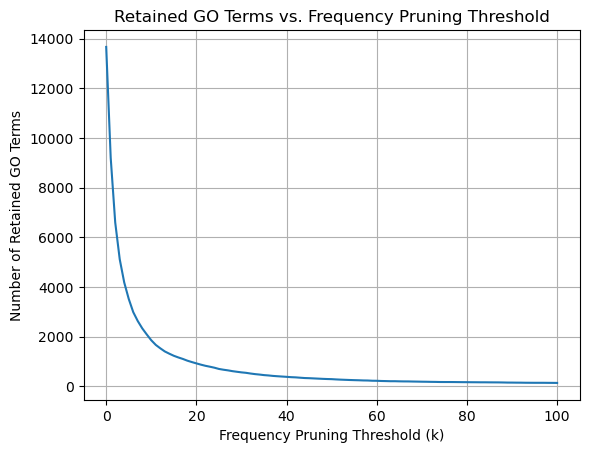

In [22]:
thresholds = np.arange(0,101,1)

num_retained_terms = []
for threshold in thresholds:
    retained_terms = [term for term, freq in term_dictionary.items() if freq > threshold]
    num_retained_terms.append(len(retained_terms))

# Plot the results
plt.plot(thresholds, num_retained_terms)
plt.xlabel("Frequency Pruning Threshold (k)")
plt.ylabel("Number of Retained GO Terms")
plt.title("Retained GO Terms vs. Frequency Pruning Threshold")
plt.grid(True)
plt.savefig("retained_go_terms_vs_threshold.png", dpi=300)
plt.show()

In [23]:
# Calculate the threshold value as...
threshold_value = 5


# Create a new dictionary with values above the threshold
new_dict = {key: value for key, value in sorted_dict.items() if value > threshold_value}



go_terms = list(new_dict.keys())

print(len(go_terms))

# Create a DataFrame with the GO terms
df = pd.DataFrame({"GO Terms": go_terms})

# Save the DataFrame to a CSV file
df.to_excel("go_terms.xlsx", index=False)

3515


In [24]:
feature_vectors = []

for index, row in cleaned_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    uniprot_ac = row['UniProtKB-AC']
    Label = row["Label"]
    go_term = row['GO Terms']

    gene_entry = next((gene for gene in feature_vectors if gene['gene_id'] == gene_id and gene['uniprot_ac'] == uniprot_ac and gene["Label"] ==Label), None)

    if gene_entry is None:
        gene_entry = {'gene_id': gene_id, 'uniprot_ac': uniprot_ac, "Label" : Label, 'feature_vector': [0] * len(go_terms)}
        feature_vectors.append(gene_entry)

    for i, term in enumerate(go_terms):
        if term == go_term:
            gene_entry['feature_vector'][i] = 1



In [25]:
data = [[gene_entry['uniprot_ac'], gene_entry['gene_id'], gene_entry['Label']] + gene_entry['feature_vector'] for gene_entry in feature_vectors]
CleanedDataForMachineLearning = pd.DataFrame(data, columns=['UniprotAC', 'GeneID', 'Label'] + go_terms)
print(CleanedDataForMachineLearning)

       UniprotAC     GeneID     Label  GO:0005634  GO:0005829  GO:0005654  \
0         F1T0I5         15  Positive           0           1           0   
1         Q16613         15  Positive           0           1           0   
2         P49588         16  Positive           0           1           0   
3         B2RUU2         19  Positive           0           0           0   
4         O95477         19  Positive           0           0           0   
...          ...        ...       ...         ...         ...         ...   
9112  A0A1X9RU27  100132074  Positive           1           0           0   
9113      B7U540  100134444  Positive           0           0           0   
9114  A0A024R7K5  100271849  Positive           0           1           1   
9115      Q02080  100271849  Positive           1           1           1   
9116      Q9Y575  100302652  Positive           0           1           0   

      GO:0005737  GO:0005886  GO:0005524  GO:0016020  ...  GO:0005295  \
0 

In [26]:
CleanedDataForMachineLearning[go_terms] = CleanedDataForMachineLearning[go_terms].astype(int).reset_index(drop=True)
#CleanedDataForMachineLearning.to_excel("CleanedDataForMachineLearning.xlsx", index=False)

print("fv done")


fv done


In [27]:
print(CleanedDataForMachineLearning.head(60))

     UniprotAC  GeneID     Label  GO:0005634  GO:0005829  GO:0005654  \
0       F1T0I5      15  Positive           0           1           0   
1       Q16613      15  Positive           0           1           0   
2       P49588      16  Positive           0           1           0   
3       B2RUU2      19  Positive           0           0           0   
4       O95477      19  Positive           0           0           0   
5       B7XCW9      19  Positive           0           0           0   
6       Q99758      21  Positive           0           0           0   
7       Q4LE27      21  Positive           0           0           0   
8       O75027      22  Positive           0           0           0   
9   A0A0S2Z2Z3      22  Positive           0           0           0   
10  A0A087WW65      22  Positive           0           0           0   
11      Q8NE71      23  Positive           0           1           1   
12  A0A1U9X609      23  Positive           0           1        

In [28]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, LabelEncoder

In [29]:
X = [data['feature_vector'] for data in list(feature_vectors)]
Y = CleanedDataForMachineLearning['Label'].tolist()

In [30]:
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(Y)

In [31]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

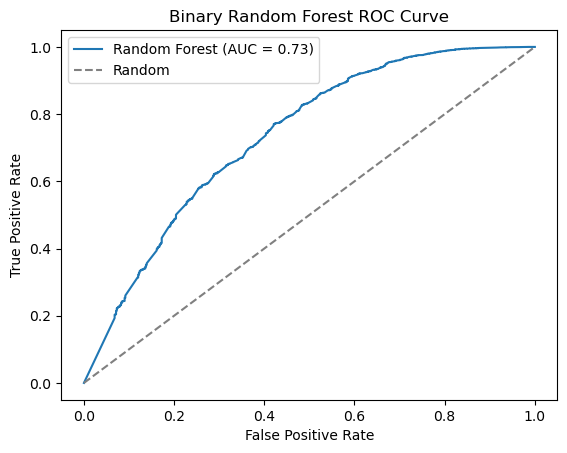

In [32]:
random_forest = RandomForestClassifier()

rf_probs = cross_val_predict(random_forest, X, y_binary, cv=cv, method='predict_proba')[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_binary, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Random Forest ROC Curve')
plt.legend()
plt.show()

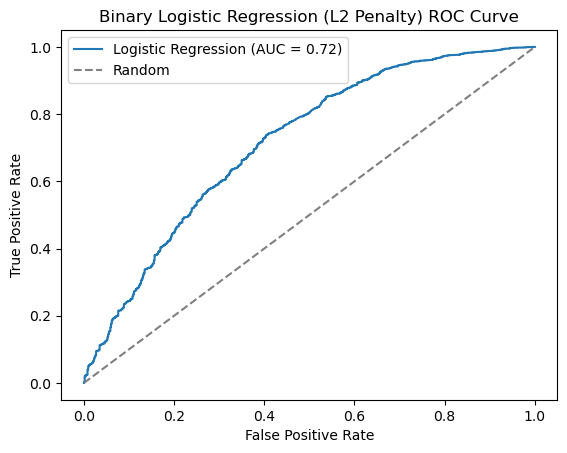

In [33]:
logistic_regression = LogisticRegression()

lr_probs = cross_val_predict(logistic_regression, X, y_binary, cv=cv, method='predict_proba')[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(y_binary, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L2 Penalty) ROC Curve')
plt.legend()
plt.show()

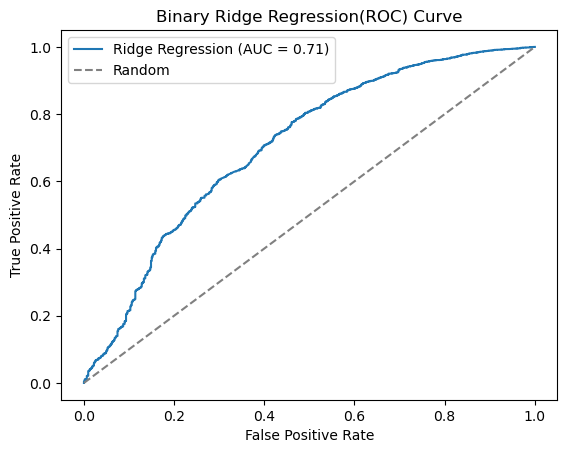

In [34]:
ridge_regression = Ridge()

ridge_probs = cross_val_predict(ridge_regression, X, y_binary, cv=cv)
ridge_fpr, ridge_tpr, _ = roc_curve(y_binary, ridge_probs)
ridge_auc = auc(ridge_fpr, ridge_tpr)

plt.plot(ridge_fpr, ridge_tpr, label=f'Ridge Regression (AUC = {ridge_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Ridge Regression ROC Curve')
plt.legend()
plt.show()

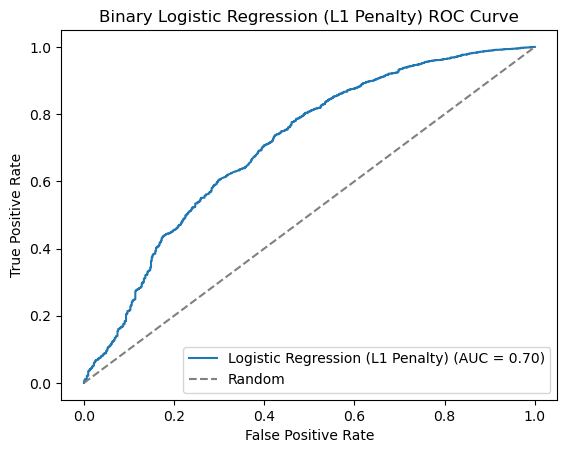

In [46]:
L1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')

l1_probs = cross_val_predict(L1, X, y_binary, cv=cv, method='predict_proba')[:, 1]
l1_fpr, l1_tpr, _ = roc_curve(y_binary, l1_probs)
l1_auc = auc(l1_fpr, l1_tpr)

plt.plot(ridge_fpr, ridge_tpr, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L1 Penalty) ROC Curve')
plt.legend()
plt.show()

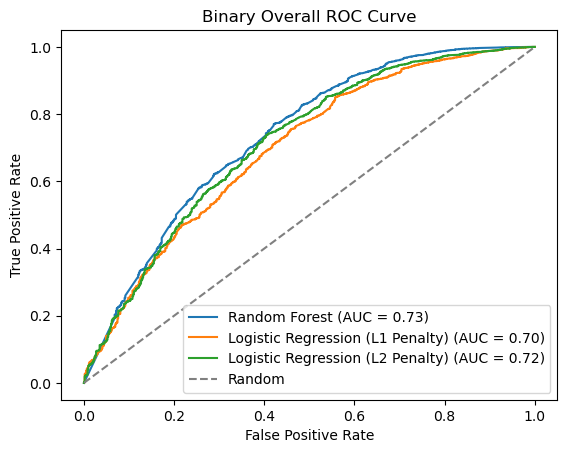

In [49]:
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(l1_fpr, l1_tpr, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc:.2f})')
#plt.plot(ridge_fpr, ridge_tpr, label=f'Ridge Regression (AUC = {ridge_auc:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Overall ROC Curve')
plt.legend()
plt.savefig('BinaryOverall.png',bbox_inches='tight')
plt.show()

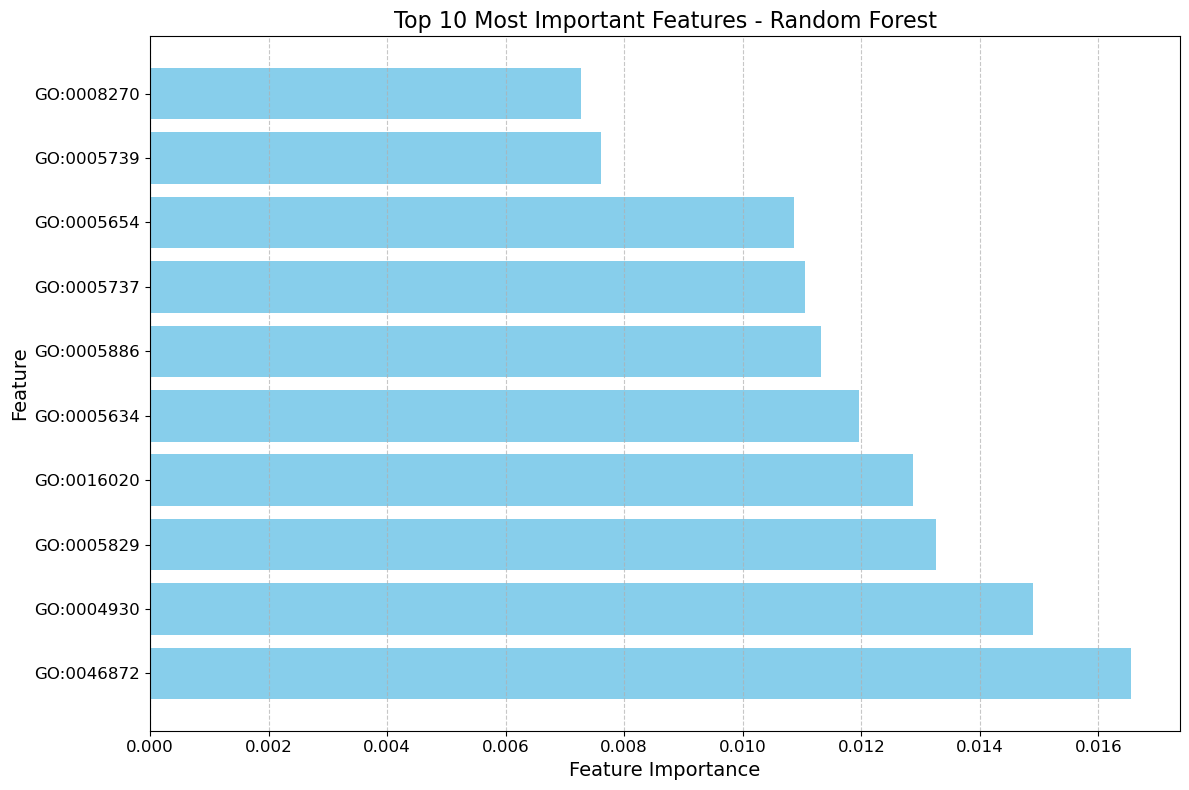

In [42]:
# Train the Random Forest model on the data
random_forest.fit(X, y_binary)

# Get feature importances from the trained Random Forest model
feature_importances = random_forest.feature_importances_

# Create a dictionary to store feature names and their corresponding importance scores
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_importances))

# Sort the features by importance in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 most important features
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

# Plot the top 10 most important features using a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Random Forest', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('FeatureImportanceRF.png', bbox_inches='tight', dpi=600)
plt.show()

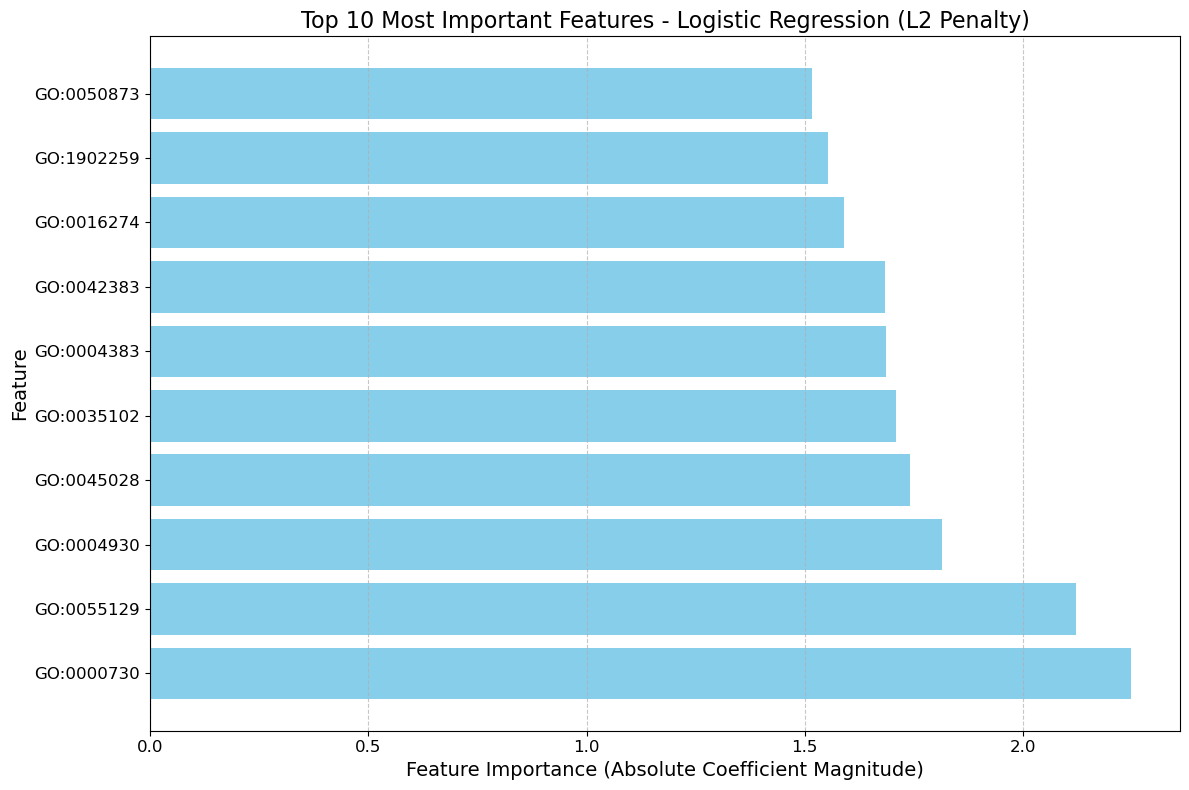

In [43]:
# Train the Logistic Regression model on the data
logistic_regression.fit(X, y_binary)

# Get the absolute feature coefficients from the trained Logistic Regression model
feature_coefficients = np.abs(logistic_regression.coef_[0])

# Create a dictionary to store feature names and their corresponding importance scores (coefficients)
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))

# Sort the features by importance (coefficients) in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 most important features
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

# Plot the top 10 most important features using a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Logistic Regression (L2 Penalty)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceLR.png', bbox_inches='tight', dpi=600)
plt.show()

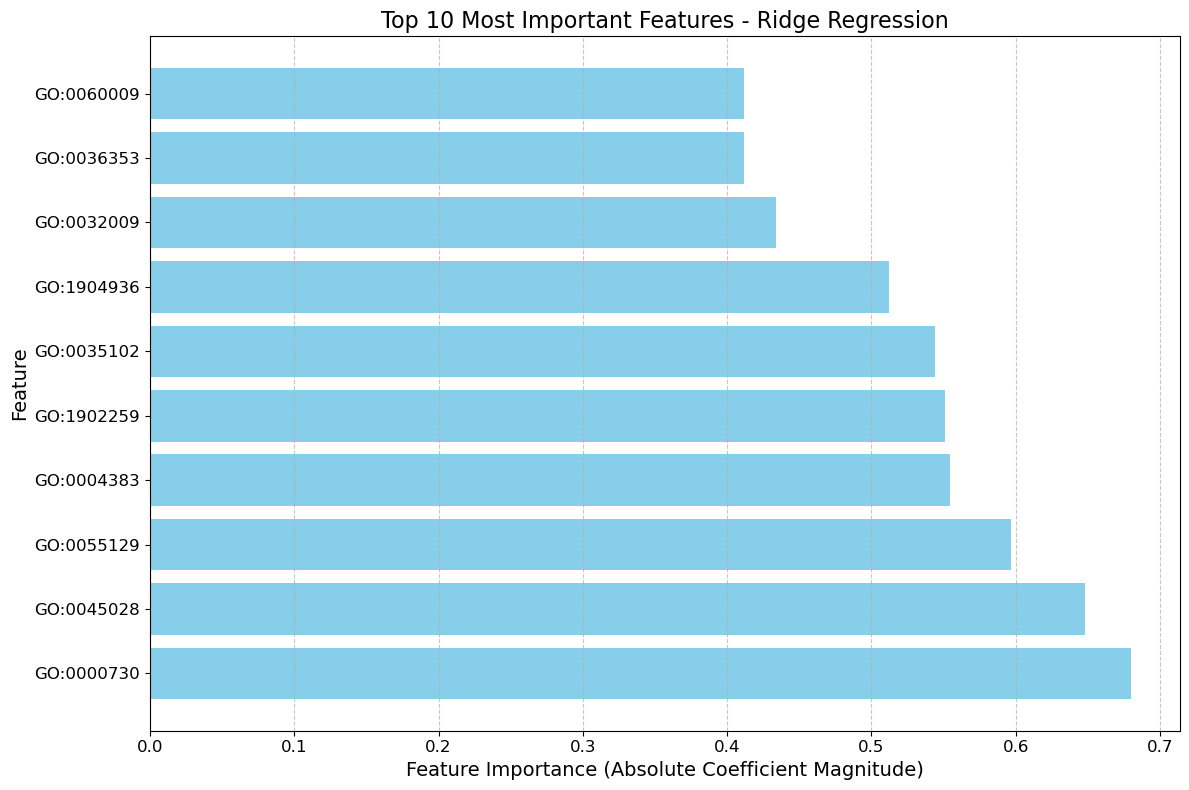

In [44]:
# Train the Ridge Regression model on the data
ridge_regression.fit(X, y_binary)

# Get the absolute feature coefficients from the trained Ridge Regression model
feature_coefficients = np.abs(ridge_regression.coef_)

# Create a dictionary to store feature names and their corresponding importance scores (coefficients)
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))

# Sort the features by importance (coefficients) in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 most important features
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

# Plot the top 10 most important features using a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Ridge Regression', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceRR.png', bbox_inches='tight', dpi=600)
plt.show()

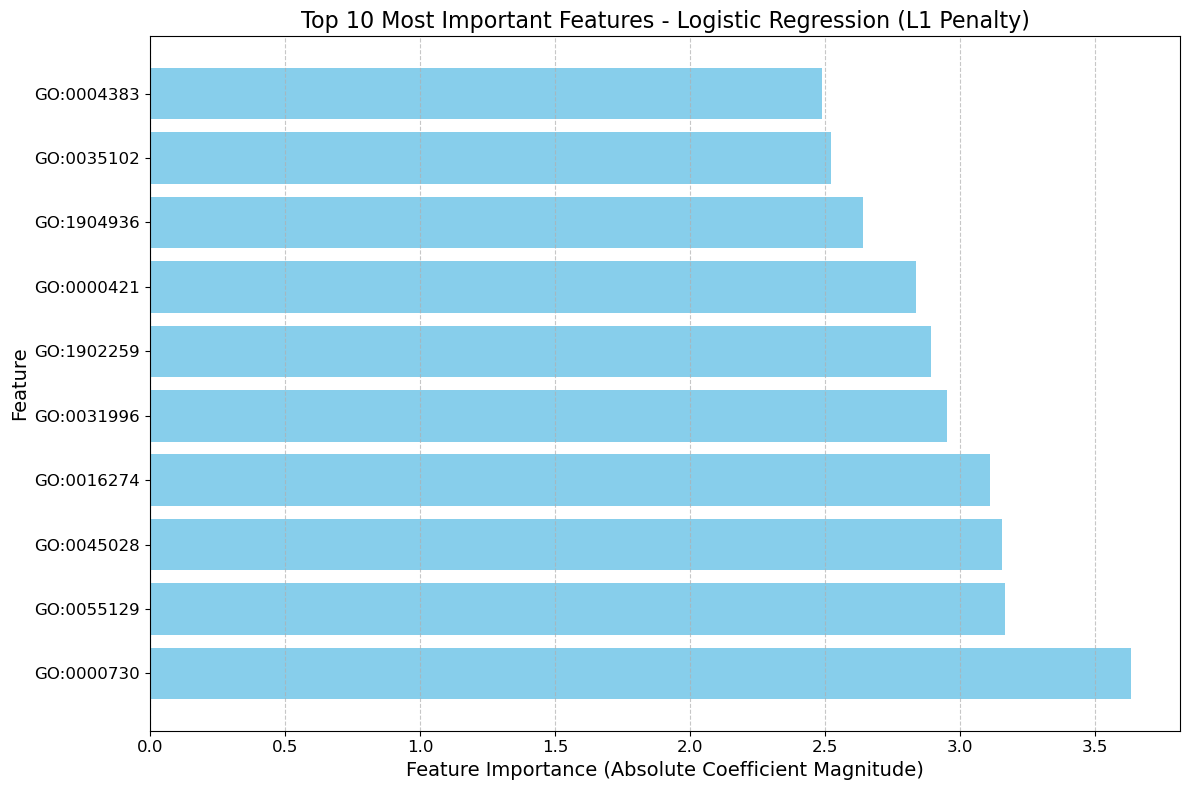

In [48]:
# Train the Logistic Regression model on the data
L1.fit(X, y_binary)

# Get the absolute feature coefficients from the trained Logistic Regression model
feature_coefficients = np.abs(L1.coef_[0])

# Create a dictionary to store feature names and their corresponding importance scores (coefficients)
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))

# Sort the features by importance (coefficients) in descending order
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 most important features
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

# Plot the top 10 most important features using a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Logistic Regression (L1 Penalty)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceL1.png', bbox_inches='tight', dpi=600)
plt.show()